In [1]:
# Should be named as faster fax testing ground
import os, sys, time
import numpy as np
from numpy import sqrt, exp, pi, square
import pandas as pd
pd.options.mode.chained_assignment = None        # default='warn'
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'   # enable if you have a retina display
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d, UnivariateSpline
import warnings
warnings.filterwarnings('ignore')
from multihist import Histdd, Hist1d
from tqdm import tqdm
from multiprocessing import Pool
from contextlib import contextmanager

def plt_config(title=None, xlim=None, ylim=None, xlabel=None, ylabel=None, colorbar=False, sci=False):
    for field in ['title', 'xlim', 'ylim', 'xlabel', 'ylabel']:
        if eval(field) != None: getattr(plt, field)(eval(field))
    if isinstance(sci, str): plt.ticklabel_format(style='sci', axis=sci, scilimits=(0,0))
    if isinstance(colorbar,str): plt.colorbar(label=colorbar)
    elif colorbar: plt.colorbar(label = '$Number\ of\ Entries$')

@contextmanager
def initiate_plot(dimx=24, dimy=9):
    plt.rcParams['figure.figsize'] = (dimx, dimy)
    global fig; fig = plt.figure()
    yield
    plt.show()

@contextmanager
def timeit():
    start = time.time()
    yield
    stop = time.time()
    print('This took %.2f seconds' % (stop-start))
    time.sleep(0.5)

In [2]:
from pax import units, utils, datastructure
from pax.configuration import load_configuration
from pax.PatternFitter import PatternFitter
from pax.InterpolatingMap import InterpolatingMap
from pax.utils import Memoize

config = load_configuration(config_names = ['XENON1T','Simulation','SR1_parameters'])

c = {}
c.update(config['DEFAULT'])
c.update(config['WaveformSimulator'])

ts = c.get('pe_pulse_ts')
ys = c.get('pe_pulse_ys')
pe_pulse_function = interp1d(ts, np.cumsum(ys)/np.sum(ys), bounds_error = False, fill_value = (0,1))

dt = c.get('sample_duration')
samples_before, samples_after = 5, 30
samples = np.linspace(-samples_before*dt, +samples_after*dt, 1+samples_before+samples_after)

pmt_current = np.diff(pe_pulse_function(samples))/dt

In [3]:
c['electron_train_probability'] = 1.3*10**-2
c['gate_electron_probability'] = 1.4*10**-3

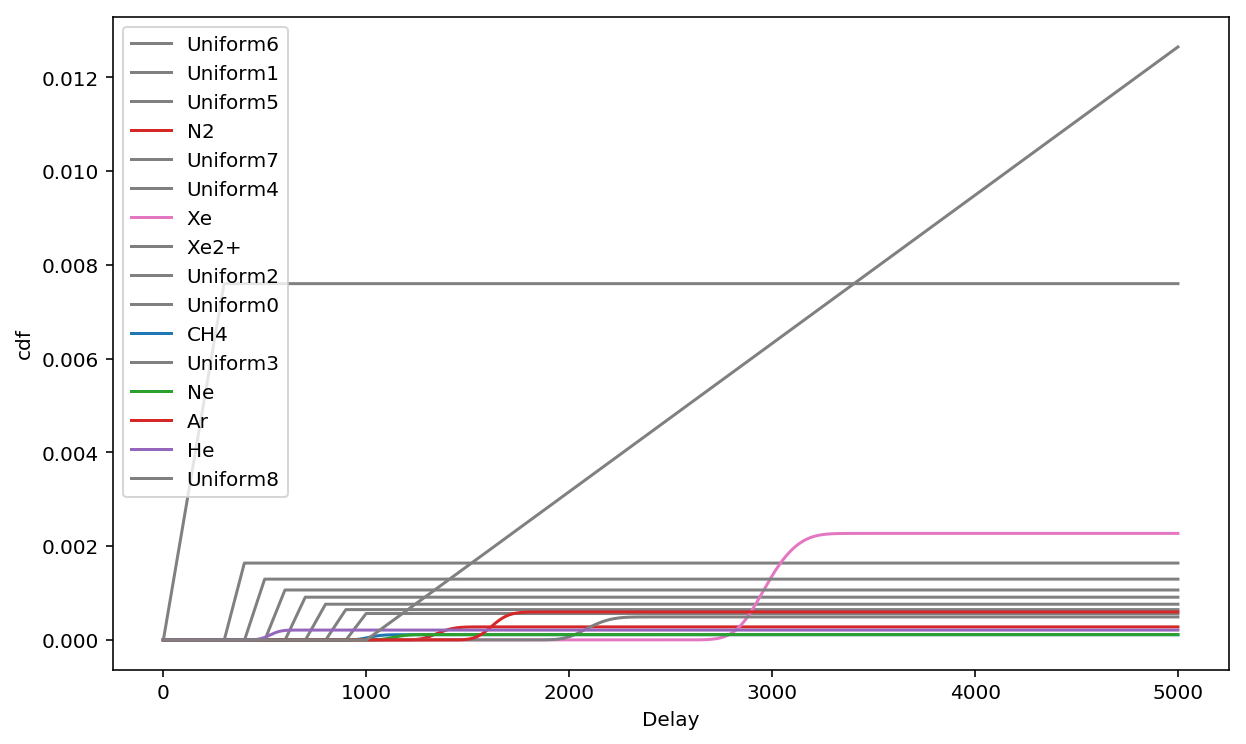

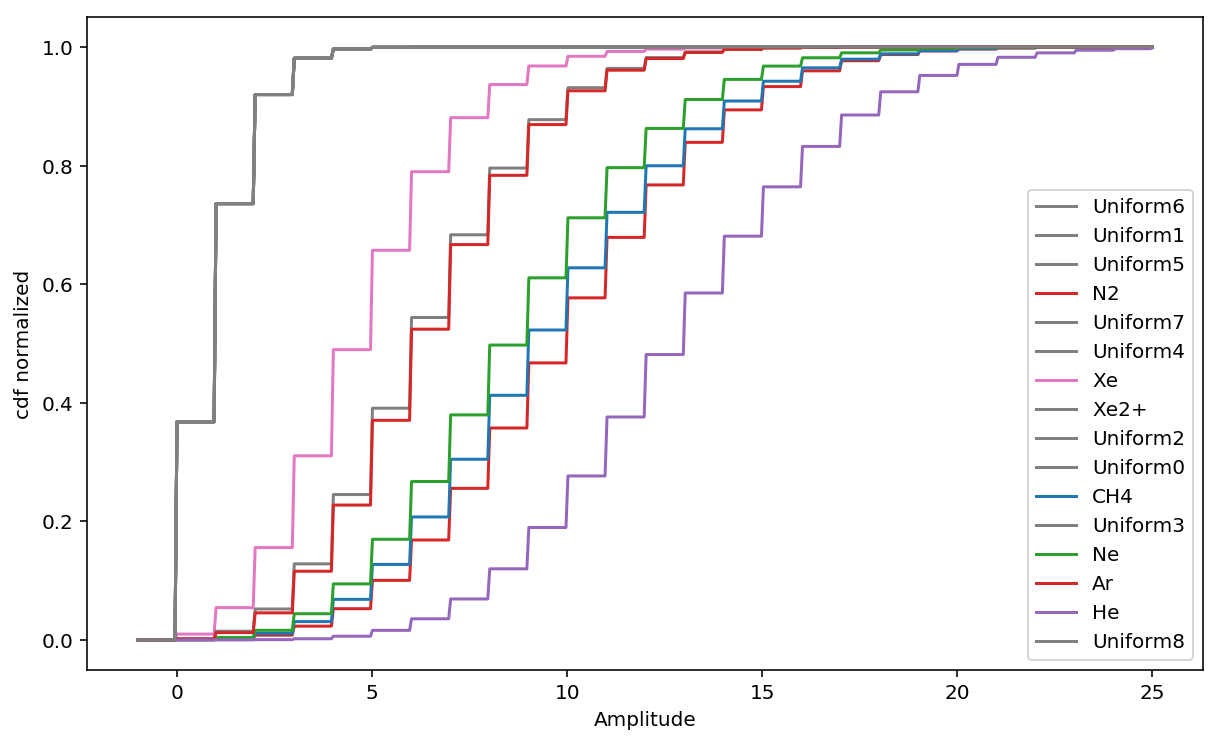

In [8]:
# To build PMT AP distributions
from scipy.stats import norm, uniform, poisson

def this_normal(x, loc=0, scale=1):
    return norm.cdf(x, loc, scale)
def this_uniform(x, low=0, high=1):
    return uniform.cdf(x, low, high-low-1)
def this_poisson(x, loc):
    return poisson.cdf(x, loc)

AP_config = pmt_ap = c['each_pmt_afterpulse_types']

n_pmt = 248
aft_weight = np.zeros(n_pmt)
aft_weight[:127] = 0.65; aft_weight[127:] = 0.35

element_list = list(pmt_ap[0].keys())
element_list.sort()

time = np.arange(5000) # in ns
size = np.linspace(-1, 25, 520) # in pe

weighted_probability = {ele:np.zeros(n_pmt) for ele in element_list}
time_dist = {ele:np.zeros(len(time)) for ele in element_list}
size_dist = {ele:np.zeros(len(size)) for ele in element_list}

for pmt_id in range(n_pmt):
    if AP_config[pmt_id]:
        for element in element_list:
            this_weighted_probability = aft_weight[pmt_id]*AP_config[pmt_id][element]['p']
            weighted_probability[element][pmt_id] = this_weighted_probability

            if 'Uniform' in element:
                time_dist[element] += this_weighted_probability*this_uniform(time, **AP_config[pmt_id][element]['time_parameters'])
                size_dist[element] += this_weighted_probability*this_poisson(size, 1)
            else:
                time_dist[element] += this_weighted_probability*this_normal(time, **AP_config[pmt_id][element]['time_parameters'])
                size_dist[element] += this_weighted_probability*this_poisson(size, AP_config[pmt_id][element]['amp_mean'])
            
    else:
        aft_weight[pmt_id] = 0
        
cycle = plt.rcParams['axes.color_cycle']
line_list = dict()
with initiate_plot(10, 6):
    for ix, key in enumerate(time_dist.keys()):
        if 'Uniform' in key:
            color='grey'
        else: color=cycle[ix%len(cycle)]
        line_list.update({key: plt.plot(time, time_dist[key]/np.sum(aft_weight), color=color, label=key)[0]})
    
    plt.legend()
    plt_config(xlabel='Delay', ylabel='cdf')

with initiate_plot(10, 6):
    for ix, key in enumerate(time_dist.keys()):
        color = line_list[key].get_color()
        plt.plot(size, size_dist[key]/np.sum(weighted_probability[key]), color=color, label=key)
        plt.legend()
    plt_config(xlabel='Amplitude', ylabel='cdf normalized')
        
time_max_proba = {ele : (time_dist[ele]/np.sum(aft_weight))[-1] for ele in element_list}
size_max_proba = {ele : (size_dist[ele]/np.sum(weighted_probability[ele]))[-1] for ele in element_list}

time_dist_icdf = {ele : interp1d(time_dist[ele]/np.sum(aft_weight), time) for ele in element_list}
size_dist_icdf = {ele : interp1d(size_dist[ele]/np.sum(weighted_probability[ele]), size) for ele in element_list}


In [9]:
from numba import int64, float64, guvectorize, vectorize, jit
def generate(t_electron):
    # Generate electron photons
    t_photon = electron_2_photon(t_electron)
    
    # Photo-ionization photons
    t_photo_ionization = photon_2_electron(t_photon)
    t_photon = np.hstack((t_photon, electron_2_photon(t_photo_ionization)))
    
    # Pmt after pulses
    t_pmt_after_pulses = photon_2_photon(t_photon)
    t_photon = np.hstack((t_photon, t_pmt_after_pulses))
    
    # Change t_photon from ns to sample index from -5000 to 25000 ns
    t_photon = np.around(t_photon, decimals = -1)
    t_photon = np.asarray((t_photon+5000)/10, dtype=int)
    w = np.zeros(3001)
    add_hit(t_photon,w)
    return w*10, len(t_photon) # Sumwaveform and peak area in pe

def electron_2_photon(electron_time):
    # Place photons acording to single electron gain and width
    nele = len(electron_time); npho = 40
    t_photon = np.random.normal(0, 220, (nele, npho))
    
    delay = np.random.choice([c['singlet_lifetime_gas'], c['triplet_lifetime_gas']], size=nele, replace=True, p=[0.0035,1-0.0035])
    electron_time += -np.log(1-np.random.uniform(0, 1, size=nele))*delay
    t_photon += np.repeat(electron_time, 40).reshape((nele, npho))
    
    probability = np.random.uniform(0, 1, (nele, npho))
    threshold = np.repeat(np.random.normal(21.3, 5, size=nele)/npho, npho).reshape((nele, npho))
    
    probability = probability<threshold
    return t_photon[probability]

def randomized_electron_train_time(n_electron):
    b = 5.2; m=725e3; k = -3.5/m;
    seed = np.random.uniform(0, 1, size=n_electron)
    seed *= b*m+0.5*k*m**2
    return ((b**2+2*k*seed)**0.5-b)/k

def photon_2_electron(photon_time):
    # Place electrons acording to photo-ionization and
    n_electron_tr = np.random.poisson(len(photon_time)*c['electron_train_probability'])
    t_electron_tr = np.random.choice(photon_time, size=n_electron_tr, replace=True)
    delay_electron_tr = randomized_electron_train_time(n_electron_tr)
    t_electron_tr += delay_electron_tr
    
    probability = np.random.uniform(0, 1, size=n_electron_tr)
    threshold = np.exp(-delay_electron_tr/c['electron_lifetime_liquid'])

    t_electron_tr = t_electron_tr[probability<threshold]
    
    n_electron_ga = np.random.poisson(len(photon_time)*c['gate_electron_probability'])
    t_electron_ga = np.random.choice(photon_time, size=n_electron_ga, replace=True)
    t_electron_ga += np.random.normal(1.37e3, 0.15e3, size=n_electron_ga)

    return np.hstack([t_electron_tr, t_electron_ga])

def photon_2_photon(photon_time):
    n_total = len(photon_time)
    keys = time_max_proba.keys()
    n_after_pulses = {key:np.random.poisson(time_max_proba[key]*n_total,1)[0] for key in keys}
    
    times = {key:np.random.uniform(0, time_max_proba[key], n_after_pulses[key]) for key in keys}
    times = {key:time_dist_icdf[key](times[key])+np.random.choice(photon_time, n_after_pulses[key]) for key in keys}
    #times = {key:time_dist_icdf[key](times[key]) for key in keys}

    sizes = {key:np.random.uniform(0, size_max_proba[key], n_after_pulses[key]) for key in keys}
    sizes = {key:size_dist_icdf[key](sizes[key]) for key in keys}
    
    return np.concatenate([np.repeat(times[key], np.asarray(sizes[key],dtype=int)) for key in keys])


@guvectorize([(int64, float64[:])], '(), (n)')
def add_hit(t_p, w):
    w[t_p-5:t_p+30] += pmt_current

In [10]:
def s2_width_model_in_fax(z):
    dif_const = 29.35
    v = .1335
    return sqrt(- 2 * dif_const * z / v ** 3)
s2_width_model_in_fax(-40.533)

1000.00351472678

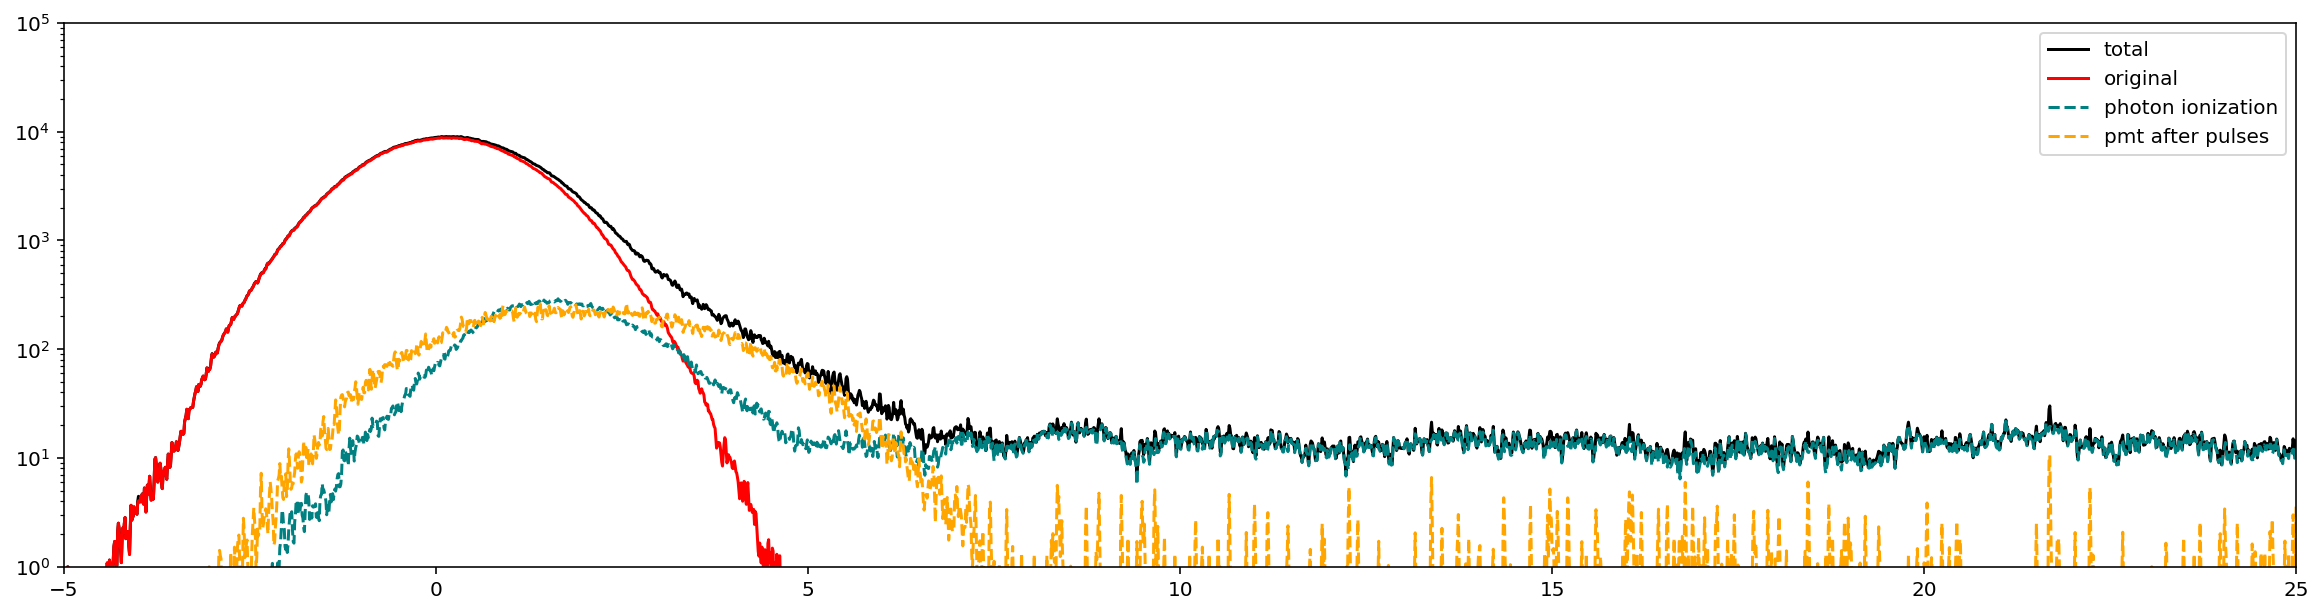

In [15]:
# Generate electron photons
t_electron = np.random.normal(0, 1e3, int(3e6/28))
t_photon = electron_2_photon(t_electron)
t_photon_ori = t_photon.copy()

# Photo-ionization photons
t_photo_ionization = electron_2_photon(photon_2_electron(t_photon))
t_photon = np.hstack((t_photon, t_photo_ionization))

# Pmt after pulses
t_pmt_after_pulses = photon_2_photon(t_photon)
t_photon = np.hstack((t_photon, t_pmt_after_pulses))

# Change t_photon from ns to sample index from -5000 to 25000 ns
t_photon = np.around(t_photon, decimals = -1)
t_photon = np.asarray((t_photon+5000)/10, dtype=int)

t_photon_ori = np.around(t_photon_ori, decimals = -1)
t_photon_ori = np.asarray((t_photon_ori+5000)/10, dtype=int)

t_photon_pi = np.around(t_photo_ionization, decimals = -1)
t_photon_pi = np.asarray((t_photon_pi+5000)/10, dtype=int)

t_photon_ap = np.around(t_pmt_after_pulses, decimals = -1)
t_photon_ap = np.asarray((t_photon_ap+5000)/10, dtype=int)

#
w = np.zeros(3001)
add_hit(t_photon,w)

w_ori = np.zeros(3001)
add_hit(t_photon_ori,w_ori)

w_pi = np.zeros(3001)
add_hit(t_photon_pi,w_pi)

w_ap = np.zeros(3001)
add_hit(t_photon_ap,w_ap)

with initiate_plot(20,5):
    ax = fig.add_subplot(111)
    x = np.linspace(-5000, 25000, 3001)/1e3
    plt.plot(x, w*10, 'k-', label='total')
    plt.plot(x, w_ori*10, 'red', ls='-', label='original')
    plt.plot(x, w_pi*10, 'teal', ls='--', label='photon ionization')
    plt.plot(x, w_ap*10, 'orange', ls='--', label='pmt after pulses')
    
    plt_config(xlim=(-5, 25), ylim=[1, 1e5])
    plt.legend()
    plt.yscale('log') 

In [13]:
def smooth_lowess(y, x, frac=1.0/2.0, it=1):
    """
    Smoothing using lowess
    return y expectation at input x positions
    """
    n = len(x)
    neighborhood = np.ceil(frac*n)

    # w_ij = (1-abs((x_j-x_i)/(neighborhood))**3)**3 if x_j IN the neighborhood of x_i
    # w_ij = 0 if x_j in NOT IN the neighborhood of x_i
    # Of corse w_ij is symmetric
    w = np.clip(np.abs((x[:,None]-x[None,:])/neighborhood), 0.0, 1.0)
    w = (1-w**3)**3

    delta = np.ones(n)
    # We use matrices to speed up calculation but memory costly
    xmatrix = np.tile(x,n).reshape(n, n) # x_*j
    ymatrix = np.tile(y,n).reshape(n, n) # y_*j

    for ix in range(it):
        wmatrix = w * np.tile(delta,n).reshape(n, n)   # w_ij * delta_*j

        # Here capital case X Y has nothing to do with lower case x y, 
        # Derived from linear regression in order to solve 'm' and 'k'
        # Ya_i=m_i+k_i*Xa_i and Yb_i=m_i+k_i*Xb_i
        Ya = np.sum(wmatrix * ymatrix, axis=1) / np.sum(wmatrix, axis=1)
        Xa = np.sum(wmatrix * xmatrix, axis=1) / np.sum(wmatrix, axis=1)
        Yb = np.sum(wmatrix * xmatrix * ymatrix, axis=1) / np.sum(wmatrix * xmatrix, axis=1)
        Xb = np.sum(wmatrix * xmatrix * xmatrix, axis=1) / np.sum(wmatrix * xmatrix, axis=1)
        
        yestimate = Ya + (Yb - Ya) / (Xb - Xa) * (x - Xa)
        residuals = y - yestimate
        s = np.median(np.abs(residuals))
        delta = np.clip(residuals / (6.0 * s), -1, 1)
        delta = (1 - delta **2 ) **2

    return yestimate

In [16]:
# Teal: sim sumwaveform
# Blue: minima
# Magenta: maxima
# Orange: smoothed waveform
# Orange vertical: cut off
# Orange horizontal: tail threshold
# Green: pseudo-gaussian-fit 

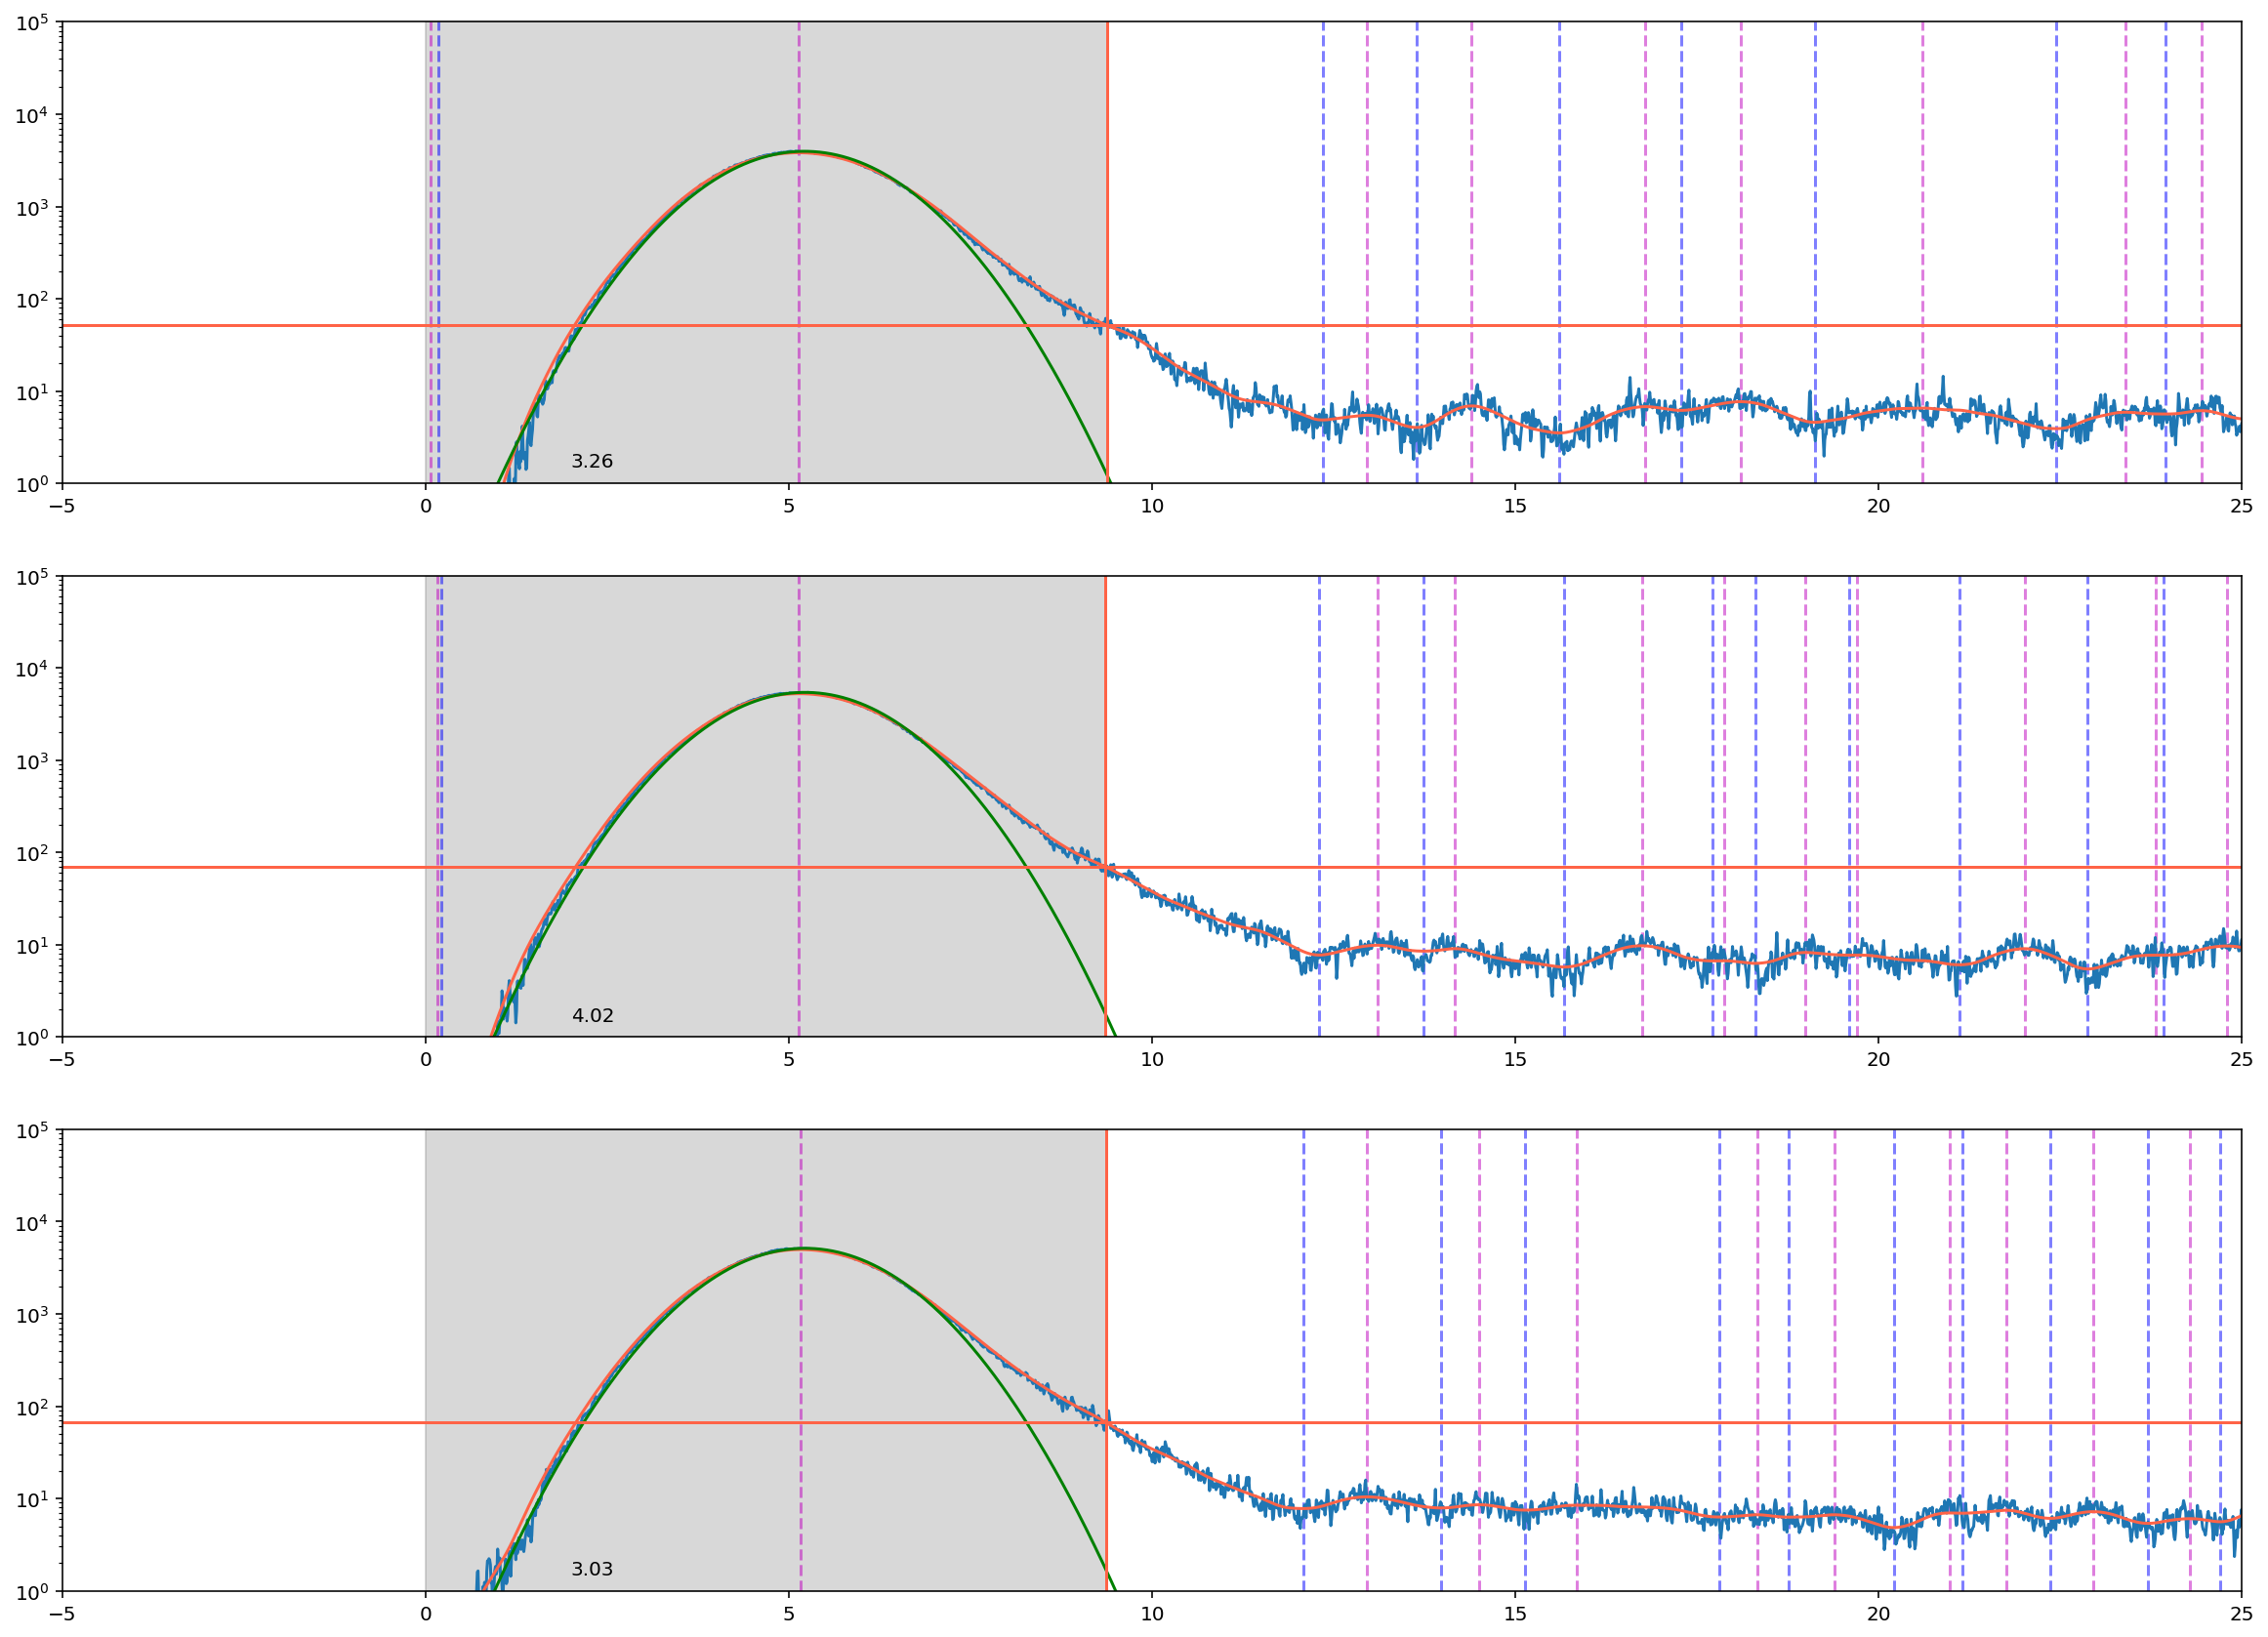

0

In [17]:
df = pd.DataFrame()
n_sim = 100
slope = 1
n_electrons   =   np.random.uniform(2.45**slope,5.**slope,n_sim)**(1/slope)
n_electrons   =   np.array( 10**n_electrons, dtype = int)

n_sim = len(n_electrons)
df['n_electrons'] = np.asarray(n_electrons, dtype=int)
df['z_sim'] = np.random.uniform(-40, -41, n_sim)

df_ = df[(df.z_sim < 0) & (df.n_electrons*28>1e6) & (df.n_electrons*28<1e7)]

from scipy.stats import norm
def gaussian(x, amp, mu, sigma):
    return amp * norm.pdf(x, loc=mu, scale=sigma)
def plot():
    with initiate_plot(20,20):
        cot = 0
        for ix, row in df_.iterrows():
            t_photon_mean = np.random.normal(0, s2_width_model_in_fax(row.z_sim), int(row.n_electrons))
            ys, a= generate(t_photon_mean)
            _ys = smooth_lowess(ys, np.arange(len(ys)), frac = 60/len(ys))

            dw = np.diff(_ys, n=1)
            x = np.arange(len(_ys))
            global minima, maxima, _ys

            minima = np.where((np.hstack((dw, -1)) > 0) & (np.hstack((1, dw)) <= 0))[0]
            maxima = np.where((np.hstack((dw, 1)) < 0) & (np.hstack((-1, dw)) >= 0))[0]

            cnt = ys>0.05*np.max(ys)

            xs = np.arange(len(ys))
            mean = np.sum(xs[cnt]*ys[cnt])/np.sum(ys[cnt])
            sigma = (np.sum((xs[cnt]-mean)**2*ys[cnt])/np.sum(ys[cnt]))**0.5
            amp = np.sum(ys[cnt]*gaussian(xs[cnt],1,mean,sigma))/np.sum(gaussian(xs[cnt],1,mean,sigma)**2)

            c = np.where(_ys<5e-5*amp)[0]
            c = c[c>mean+2*sigma]
            
            if len(maxima) > 0:minima = minima[(minima>maxima[0]) & (minima<maxima[-1])]
                
                
            cot+=1
            if cot == 4 : return 0
            ax = fig.add_subplot(411+cot)
            for ix in x[minima]:plt.axvline(ix/100, color='b', ls='--', alpha=0.5)
            for ix in x[maxima]:plt.axvline(ix/100, color='m', ls='--', alpha=0.5)
            plt.plot(np.arange(len(ys))/100, ys)
            plt.plot(np.arange(len(_ys))/100, _ys, color='tomato')
            plt.plot(xs/100, gaussian(xs, amp, mean, sigma), color = 'g')
            if len(c)>0:
                plt.axvline(c[0]/100, color = 'tomato')
                plt.axvspan(0, c[0]/100, alpha=0.3, color='grey')
            plt.axhline(5e-5*amp, color='tomato')
            plt_config(xlim=[-5, 25], ylim=[1, 1e5])

            gs = 0
            if len(maxima) > 0:
                gs = max(np.max(_ys[maxima][1:] - _ys[minima][:]), np.max(_ys[maxima][:-1] - _ys[minima][:]))
                gs = np.max([min(_ys[maxima][ix+1],np.max(_ys[maxima][:ix+1]))-_ys[minima][ix] for ix in range(len(minima))])
                plt.text(2,1.5,'%.2f'%(gs))
                
            plt.yscale('log')
plot()